# Number of components and sampling effect

Before using average power readings by component's size as a representation of power generated from distributed PV generation under each zip code, there are several points we would like to investigate. We would like to see if is any shift in power representation if we use different set of data. Now we are investigating how number of components in sampling affects average power reading that we would like to model. We would like to if our sampling pool of our data is homogenous enough to make consistent average power readings.

First, let's pull up data and summary of number of components in a zip code broken down by first time stamp and size of components.

In [60]:
#specify data source, zipcode (along with latitude, longitue, and timezone), and bin values to calculate mean.
datasource = 'L'
[zipcode, latitude, longitude, localtz] = ['08641', 40.0449, -74.5892, 'US/Eastern']
#binvalue = [0.60000000000000009, 1.5531428571428569, 2.5209606741573034, 4.1015736906211933, 7.487476098503139, 12.943637931034482]
#[zipcode, latitude, longitude, localtz] = ['92562', 33.5686, -117.2530, 'US/Pacific']
#binvalue = [0.6366666666666666, 1.5599424405242481, 2.4851360650682972, 3.9649782737139554, 6.7641328892898853, 12.809405655777667]

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import pytz
import os
import patsy #for spline regression
import scipy #for non-negative least square 
import scipy as sp 
from scipy import stats
from scipy.optimize import nnls
from numpy.linalg import inv #for matrix and statistics
import scipy as sp
import math
import statsmodels.api as sm
import random
%matplotlib inline

In [62]:
#mainDir = 'C:/Users/Tee/Dropbox/Active/EnergyProject/Thesis/PVreadingsStudies/main'
mainDir = 'C:\Users\Admin\Dropbox\Active\EnergyProject\Thesis'
#read data and metadata
metadata = pd.read_csv(mainDir+ '/data/solar/' + datasource +'/' + zipcode +'/metadata.csv',
                             dtype={'componentId':'object','zip':'object'})
data = pd.read_csv(mainDir+ '/data/solar/' + datasource +'/'+ zipcode+'/data.csv',
                             dtype={'componentId':'object'})
#convert timestamp string to datetime format if needed
#metadata['FirstTimestamp'] = metadata['FirstTimestamp'].map(lambda x: datetime.datetime.strptime(x,"%Y-%m-%d %H:%M:%S"))
#data['tsLocal'] = data['tsLocal'].map(lambda x: datetime.datetime.strptime(x,"%Y-%m-%d %H:%M:%S"))

In [63]:
FirstTimestampBinList = ['pre-2013','2013-1','2013-2','2013-3','2013-4','2014-1','2014-2','2014-3','2014-4']
SizeBinList = ['0-1 kW','1-2 kW','2-3 kW','3-5 kW', '5-10 kW', '10-20 kW', '20-50 kW', '50-100 kW', '<20 kW', '>20 kW','unknown','sum']
targetsizelist= ['0-1 kW','1-2 kW','2-3 kW','3-5 kW', '5-10 kW', '10-20 kW']
NumberOfComponents = pd.DataFrame(0, index = FirstTimestampBinList, columns = SizeBinList)

#define quick function to add data
def add_data(NumberOfComponents, d, i):
    NumberOfComponents['0-1 kW'].iloc[i] = d[d.sizeBucket=='0-1 kW'].shape[0]
    NumberOfComponents['1-2 kW'].iloc[i] = d[d.sizeBucket=='1-2 kW'].shape[0]
    NumberOfComponents['2-3 kW'].iloc[i] = d[d.sizeBucket=='2-3 kW'].shape[0]
    NumberOfComponents['3-5 kW'].iloc[i] = d[d.sizeBucket=='3-5 kW'].shape[0]
    NumberOfComponents['5-10 kW'].iloc[i] = d[d.sizeBucket=='5-10 kW'].shape[0]
    NumberOfComponents['10-20 kW'].iloc[i] = d[d.sizeBucket=='10-20 kW'].shape[0]
    NumberOfComponents['20-50 kW'].iloc[i] = d[d.sizeBucket=='20-50 kW'].shape[0]
    NumberOfComponents['50-100 kW'].iloc[i] = d[d.sizeBucket=='50-100 kW'].shape[0]
    NumberOfComponents['<20 kW'].iloc[i] = d[d.sizeBucket=='0-1 kW'].shape[0] + d[d.sizeBucket=='1-2 kW'].shape[0] +\
                                          d[d.sizeBucket=='2-3 kW'].shape[0] + d[d.sizeBucket=='3-5 kW'].shape[0] +\
                                            d[d.sizeBucket=='5-10 kW'].shape[0] + d[d.sizeBucket=='10-20 kW'].shape[0]
    NumberOfComponents['>20 kW'].iloc[i] = d[d.sizeBucket=='20-50 kW'].shape[0] + d[d.sizeBucket=='50-100 kW'].shape[0]
    NumberOfComponents['unknown'].iloc[i] = d[pd.isnull(d.sizeBucket)].shape[0]
    NumberOfComponents['sum'].iloc[i] = d.shape[0]
    return NumberOfComponents;

d = metadata[metadata.FirstTimestamp.map(lambda x: (x <= '2013-01-01 00:00:00'))]
NumberOfComponents = add_data(NumberOfComponents, d, 0)
d = metadata[metadata.FirstTimestamp.map(lambda x: (x > '2013-01-01 00:00:00')&(x <= '2013-04-01 00:00:00'))]
NumberOfComponents = add_data(NumberOfComponents, d, 1)
d = metadata[metadata.FirstTimestamp.map(lambda x: (x > '2013-04-01 00:00:00')&(x <= '2013-07-01 00:00:00'))]
NumberOfComponents = add_data(NumberOfComponents, d, 2)
d = metadata[metadata.FirstTimestamp.map(lambda x: (x > '2013-07-01 00:00:00')&(x <= '2013-10-01 00:00:00'))]
NumberOfComponents = add_data(NumberOfComponents, d, 3)
d = metadata[metadata.FirstTimestamp.map(lambda x: (x > '2013-10-01 00:00:00')&(x <= '2014-01-01 00:00:00'))]
NumberOfComponents = add_data(NumberOfComponents, d, 4)
d = metadata[metadata.FirstTimestamp.map(lambda x: (x > '2014-01-01 00:00:00')&(x <= '2014-04-01 00:00:00'))]
NumberOfComponents = add_data(NumberOfComponents, d, 5)
d = metadata[metadata.FirstTimestamp.map(lambda x: (x > '2014-04-01 00:00:00')&(x <= '2014-07-01 00:00:00'))]
NumberOfComponents = add_data(NumberOfComponents, d, 6)
d = metadata[metadata.FirstTimestamp.map(lambda x: (x > '2014-07-01 00:00:00')&(x <= '2014-10-01 00:00:00'))]
NumberOfComponents = add_data(NumberOfComponents, d, 7)
d = metadata[metadata.FirstTimestamp.map(lambda x: (x > '2014-10-01 00:00:00')&(x <= '2015-01-01 00:00:00'))]
NumberOfComponents = add_data(NumberOfComponents, d, 8)

Let's assign size of each components based on the middle value of each bin.

In [64]:
metadata['size'] = float('NaN')
if not metadata[metadata.sizeBucket == '0-1 kW'].shape[0]==0:
    metadata.loc[metadata.sizeBucket == '0-1 kW','size'] = binvalue[0]
if not metadata[metadata.sizeBucket == '1-2 kW'].shape[0]==0:
    metadata.loc[metadata.sizeBucket == '1-2 kW','size'] = binvalue[1]
if not metadata[metadata.sizeBucket == '2-3 kW'].shape[0]==0:
    metadata.loc[metadata.sizeBucket == '2-3 kW','size']  = binvalue[2]
if not metadata[metadata.sizeBucket == '3-5 kW'].shape[0]==0:
    metadata.loc[metadata.sizeBucket == '3-5 kW','size']  = binvalue[3]
if not metadata[metadata.sizeBucket == '5-10 kW'].shape[0]==0:
    metadata.loc[metadata.sizeBucket == '5-10 kW','size']  = binvalue[4]
if not metadata[metadata.sizeBucket == '10-20 kW'].shape[0]==0:
    metadata.loc[metadata.sizeBucket == '10-20 kW','size']  = binvalue[5]

Here we compute average size of components with <20 kW size. Note that we are interesed in components with <20 kW size. This quantity will be useful later.

In [65]:
NumberOfComponents['average size*'] = (NumberOfComponents['0-1 kW']*binvalue[0] + NumberOfComponents['1-2 kW']*binvalue[1] +\
                    NumberOfComponents['2-3 kW']*binvalue[2] + NumberOfComponents['3-5 kW']*binvalue[3] +\
                    NumberOfComponents['5-10 kW']*binvalue[4] + NumberOfComponents['10-20 kW']*binvalue[5])/\
                    (NumberOfComponents['0-1 kW'] + NumberOfComponents['1-2 kW'] +\
                    NumberOfComponents['2-3 kW'] + NumberOfComponents['3-5 kW']+ NumberOfComponents['5-10 kW'] +\
                     NumberOfComponents['10-20 kW'])
    
NumberOfComponents

,0-1 kW,1-2 kW,2-3 kW,3-5 kW,5-10 kW,10-20 kW,20-50 kW,50-100 kW,<20 kW,>20 kW,unknown,sum,average size*
pre-2013,0,0,0,0,0,5,10,0,5,10,2,17,12.809406
2013-1,0,0,0,0,4,36,61,0,40,61,37,138,12.204878
2013-2,0,0,0,1,8,3,1,0,12,1,6,19,8.042188
2013-3,0,0,0,1,64,16,1,0,81,1,76,158,7.923703
2013-4,0,0,2,1,48,48,7,0,99,7,179,285,9.580456
2014-1,0,0,0,0,0,4,14,4,4,18,97,119,12.809406
2014-2,0,0,0,0,0,0,0,0,0,0,0,0,inf
2014-3,0,0,0,0,0,0,0,0,0,0,0,0,inf
2014-4,0,0,0,0,0,0,0,0,0,0,2,2,inf


In [66]:
metadata_original = metadata
metadata = metadata[metadata['size'] <= 20]
data_original = data
data = data[['tsLocal','altitude','azimuth']+list(metadata['componentId'])]

Define helpful function for date alignement called DOY (Day of year: 1-364).

In [67]:
def DOY (timestamp): #Stand for "Day of Year"
    if (type(timestamp) is str):
        if len(timestamp) == 19:
            Date = datetime.datetime.strptime(timestamp,"%Y-%m-%d %H:%M:%S").date()
        if len(timestamp) == 10:
            Date = datetime.datetime.strptime(timestamp,"%Y-%m-%d").date()
    elif (type(timestamp) is datetime.date):
        Date = timestamp
    elif (type(timestamp) is datetime.datetime):
        Date= timestamp.date()
    else:
        print 'not valid time object'
    y = str(Date.year)
    NewYear = datetime.datetime.strptime(y+'-01-01',"%Y-%m-%d").date()
    d = (Date - NewYear).days
    if (int(y)%4==0)&(Date > datetime.datetime.strptime(y+'-02-28',"%Y-%m-%d").date()): #leap year correction
        d = d-1
    return d;

#one can compute DBW ("Day Before Winter Solstice") by substracting DOY with 355. as  DOY ("2014-12-22 00:00:00") = 355.

Another helpful function is daily total energy production and daily maximum total power reading for a set of components.

In [68]:
def datacrunch(dat):
    dat = dat.set_index(['tsLocal','altitude','azimuth'])
    presencecheck = dat.notnull()
    dat['totalpower'] = dat.sum(axis=1)
    for i in presencecheck.columns.values:
        presencecheck[i] = presencecheck[i]*metadata[metadata.componentId == i]['size'].iloc[0]
    dat['totalsize'] = presencecheck.sum(axis=1)
    dat['power'] = dat['totalpower']/dat['totalsize']
    dat.reset_index(inplace=True)
    dat['date'] = dat.tsLocal.map(lambda x: x[0:10])
    summary1 = (dat[['date','power']].groupby(['date']))['power'].agg({'E' : lambda x: x.sum(skipna=False)*15/60, \
                                                                       'm' : lambda x: x.max(skipna=False)})
    summary2 = (dat[['date','totalsize']].groupby(['date']))['totalsize'].agg({'totalsize_min' : np.min, \
                                                                                'totalsize_max' : np.max})
    dailysummary = pd.concat([summary1, summary2],axis=1)
    dailysummary.reset_index(inplace = True)
    return [dat[['tsLocal','power','totalsize']],dailysummary];


## Number of components effect: Central Limit Theorem?

Here we would like to if number of components affect average power readings or not. We would like draw random components to form a group of size 4, 9, 16, 25 and so on.  In order to make a fair comparison, we would like to fix a same time period of consideration.

In [69]:
d=data[data.tsLocal.map(lambda x: (x > '2014-01-01 00:00:00')&(x <= '2015-01-01 00:00:00'))]
ComponentsOfInterest = list(metadata.componentId[metadata.FirstTimestamp <= '2014-01-01 00:00:00'])
len(ComponentsOfInterest)

237

We may repeat the sampling for 10 times. Here one can see that as the number of components used in averaging increases, fluctuation in E and m decreases. 

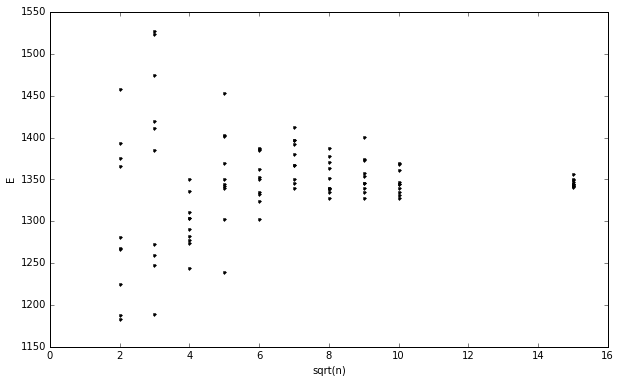

In [72]:
#For plots in thesis

fig = plt.figure(figsize=(10,6))
ax1  = fig.add_subplot(111)
#ax1.set_title('2014 E: number of components')
ax1.set_xlabel('sqrt(n)')
ax1.set_xlim([0,16])
ax1.set_ylabel('E')

if zipcode == '92562':
    QuickComparison = pd.DataFrame(['004','009','016','025','036','049','064','081'], columns = ['NumberOfComponents'])
if zipcode == '08641':
    QuickComparison = pd.DataFrame(['004','009','016','025','036','049','064','081','100','225'], 
                                   columns = ['NumberOfComponents'])

for i in range(0,10):
    d004 = d[['tsLocal','altitude','azimuth']+ random.sample(ComponentsOfInterest, 4)]
    d009 = d[['tsLocal','altitude','azimuth']+ random.sample(ComponentsOfInterest, 9)]
    d016 = d[['tsLocal','altitude','azimuth']+ random.sample(ComponentsOfInterest, 16)]
    d025 = d[['tsLocal','altitude','azimuth']+ random.sample(ComponentsOfInterest, 25)]
    d036 = d[['tsLocal','altitude','azimuth']+ random.sample(ComponentsOfInterest, 36)]
    d049 = d[['tsLocal','altitude','azimuth']+ random.sample(ComponentsOfInterest, 49)]
    d064 = d[['tsLocal','altitude','azimuth']+ random.sample(ComponentsOfInterest, 64)]
    d081 = d[['tsLocal','altitude','azimuth']+ random.sample(ComponentsOfInterest, 81)]
    if zipcode == '08641':
        d100 = d[['tsLocal','altitude','azimuth']+ random.sample(ComponentsOfInterest, 100)]
        d225 = d[['tsLocal','altitude','azimuth']+ random.sample(ComponentsOfInterest, 225)]
   
    [dat1, dailysummary1] = datacrunch(d004)
    [dat2, dailysummary2] = datacrunch(d009)
    [dat3, dailysummary3] = datacrunch(d016)
    [dat4, dailysummary4] = datacrunch(d025)
    [dat5, dailysummary5] = datacrunch(d036)
    [dat6, dailysummary6] = datacrunch(d049)
    [dat7, dailysummary7] = datacrunch(d064)
    [dat8, dailysummary8] = datacrunch(d081)
    if zipcode == '08641':
        [dat9, dailysummary9] = datacrunch(d100)
        [dat10, dailysummary10] = datacrunch(d225)
    
    comparisonindex = (pd.notnull(dailysummary1.E))&(pd.notnull(dailysummary2.E))&(pd.notnull(dailysummary3.E))& \
                        (pd.notnull(dailysummary4.E))&(pd.notnull(dailysummary5.E))&(pd.notnull(dailysummary6.E))& \
                        (pd.notnull(dailysummary7.E))
    if zipcode == '08641':
        comparisonindex = comparisonindex&(pd.notnull(dailysummary8.E))&(pd.notnull(dailysummary9.E))     
    
    if zipcode == '92562':
        QuickComparison['E'+str(i)] =  [np.sum(dailysummary1.E[comparisonindex]),np.sum(dailysummary2.E[comparisonindex]),\
                                              np.sum(dailysummary3.E[comparisonindex]),np.sum(dailysummary4.E[comparisonindex]),\
                                              np.sum(dailysummary5.E[comparisonindex]),np.sum(dailysummary6.E[comparisonindex]),\
                                              np.sum(dailysummary7.E[comparisonindex]),np.sum(dailysummary8.E[comparisonindex])]
    if zipcode == '08641':
        QuickComparison['E'+str(i)] =  [np.sum(dailysummary1.E[comparisonindex]),np.sum(dailysummary2.E[comparisonindex]),\
                                              np.sum(dailysummary3.E[comparisonindex]),np.sum(dailysummary4.E[comparisonindex]),\
                                              np.sum(dailysummary5.E[comparisonindex]),np.sum(dailysummary6.E[comparisonindex]),\
                                              np.sum(dailysummary7.E[comparisonindex]),np.sum(dailysummary8.E[comparisonindex]),\
                                              np.sum(dailysummary9.E[comparisonindex]),np.sum(dailysummary10.E[comparisonindex])]
   
    if zipcode == '92562':
        ax1.plot([2,3,4,5,6,7,8,9], QuickComparison['E'+str(i)], '.',color = 'black')
    if zipcode == '08641':
        ax1.plot([2,3,4,5,6,7,8,9,10,15], QuickComparison['E'+str(i)], '.',color = 'black')
    #ax2.plot([2,3,4,5,6,7,10,15,np.sqrt(237)], QuickComparison['average m over year'], '.',color = 'blue')
    #QuickComparison['average m over year']

fig.show()

In [73]:
Q = QuickComparison.drop('NumberOfComponents', 1)
if zipcode == '92562':
    N = 8
if zipcode == '08641':
    N = 10
l = [0]*N
for i in range(0,N):
    el = Q.loc[i,:]
    l[i] = np.mean(np.absolute(el-np.mean(el)))/np.mean(el)

l

[0.060055914172825547,
 0.075002330773528178,
 0.018241759203919464,
 0.030858102537081815,
 0.016835566178126388,
 0.015180036924151924,
 0.01294457090302072,
 0.012533321656499796,
 0.0086485608154307312,
 0.0028507719609342733]

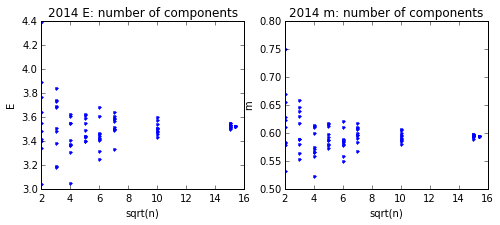

In [29]:
fig = plt.figure(figsize=(8,3))
ax1  = fig.add_subplot(121)
ax2  = fig.add_subplot(122)
ax1.set_title('2014 E: number of components')
ax2.set_title('2014 m: number of components')
ax1.set_xlabel('sqrt(n)')
ax1.set_ylabel('E')
ax2.set_xlabel('sqrt(n)')
ax2.set_ylabel('m')
for i in range(0,10):
    d004 = d[['tsLocal','altitude','azimuth']+ random.sample(ComponentsOfInterest, 4)]
    d009 = d[['tsLocal','altitude','azimuth']+ random.sample(ComponentsOfInterest, 9)]
    d016 = d[['tsLocal','altitude','azimuth']+ random.sample(ComponentsOfInterest, 16)]
    d025 = d[['tsLocal','altitude','azimuth']+ random.sample(ComponentsOfInterest, 25)]
    d036 = d[['tsLocal','altitude','azimuth']+ random.sample(ComponentsOfInterest, 36)]
    d049 = d[['tsLocal','altitude','azimuth']+ random.sample(ComponentsOfInterest, 49)]
    d100 = d[['tsLocal','altitude','azimuth']+ random.sample(ComponentsOfInterest, 100)]
    d225 = d[['tsLocal','altitude','azimuth']+ random.sample(ComponentsOfInterest, 225)]
    dful = d[['tsLocal','altitude','azimuth']+ ComponentsOfInterest]
    [dat1, dailysummary1] = datacrunch(d004)
    [dat2, dailysummary2] = datacrunch(d009)
    [dat3, dailysummary3] = datacrunch(d016)
    [dat4, dailysummary4] = datacrunch(d025)
    [dat5, dailysummary5] = datacrunch(d036)
    [dat6, dailysummary6] = datacrunch(d049)
    [dat7, dailysummary7] = datacrunch(d100)
    [dat8, dailysummary8] = datacrunch(d225)
    [dat9, dailysummary9] = datacrunch(dful)
    comparisonindex = (pd.notnull(dailysummary1.E))&(pd.notnull(dailysummary2.E)&(pd.notnull(dailysummary3.E))& \
                        pd.notnull(dailysummary4.E))&(pd.notnull(dailysummary5.E)&(pd.notnull(dailysummary6.E))& \
                        pd.notnull(dailysummary7.E))&(pd.notnull(dailysummary8.E)&(pd.notnull(dailysummary9.E))                                                  )
    QuickComparison = pd.DataFrame(['004','009','016','025','036','049','100','225','full'], columns = ['NumberOfComponents'])
    QuickComparison['average E over year'] =  [np.mean(dailysummary1.E[comparisonindex]),np.mean(dailysummary2.E[comparisonindex]),\
                                              np.mean(dailysummary3.E[comparisonindex]),np.mean(dailysummary4.E[comparisonindex]),\
                                              np.mean(dailysummary5.E[comparisonindex]),np.mean(dailysummary6.E[comparisonindex]),\
                                              np.mean(dailysummary7.E[comparisonindex]),np.mean(dailysummary8.E[comparisonindex]),\
                                              np.mean(dailysummary9.E[comparisonindex])]
    QuickComparison['average m over year'] = [np.mean(dailysummary1.m[comparisonindex]),np.mean(dailysummary2.m[comparisonindex]),\
                                              np.mean(dailysummary3.m[comparisonindex]),np.mean(dailysummary4.m[comparisonindex]),\
                                              np.mean(dailysummary5.m[comparisonindex]),np.mean(dailysummary6.m[comparisonindex]),\
                                              np.mean(dailysummary7.m[comparisonindex]),np.mean(dailysummary8.m[comparisonindex]),\
                                              np.mean(dailysummary9.m[comparisonindex])]
    QuickComparison['average E/(1 kW * 1 day)'] = QuickComparison['average E over year']/24
    QuickComparison['average m/(1 kW)'] = QuickComparison['average m over year']
    ax1.plot([2,3,4,5,6,7,10,15,np.sqrt(237)], QuickComparison['average E over year'], '.',color = 'blue')
    ax2.plot([2,3,4,5,6,7,10,15,np.sqrt(237)], QuickComparison['average m over year'], '.',color = 'blue')
    QuickComparison['average m over year']

fig.show()

Here one can see that if we sample about 50 components in a zip code, we will have power readings that fluctuate within about 5%, which is same order as the temporal effect previously. This gives a rough number of how many components needed to construct a model. 

In [30]:
QuickComparison

,NumberOfComponents,average E over year,average m over year,average E/(1 kW * 1 day),average m/(1 kW)
0,004,3.416996,0.582737,0.142375,0.582737
1,009,3.482405,0.589367,0.145100,0.589367
2,016,3.378517,0.575643,0.140772,0.575643
3,025,3.620662,0.615806,0.150861,0.615806
4,036,3.413021,0.580488,0.142209,0.580488
5,049,3.565026,0.600360,0.148543,0.600360
6,100,3.435958,0.580068,0.143165,0.580068
7,225,3.519788,0.593778,0.146658,0.593778
8,full,3.528344,0.595250,0.147014,0.595250


In [33]:
0.03/0.6

0.05

## Homogeneity of data pool

For this particular zip code and this data set, we have reach fluctuation level of 5% by using only 50 components. It means that our data pool is quite homogeneous. With this, we have enough components to construct model of average PV power output under this zip code since we have 237 residential-size components.